In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import pandas as pd
import requests
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
def fetch_expiry_dates(index):
    """Fetches list of expiry dates for the specified index."""
    expiry_api_url = f"https://live.markethound.in/api/history/expiries?index={index}"
    try:
        response = requests.get(expiry_api_url)
        response.raise_for_status()
        expiry_info = response.json()
        expiry_dates = expiry_info.get('result', [])
        return expiry_dates
    except requests.RequestException as e:
        print("Error fetching expiry data:", e)
        return []

def fetch_straddle_theta_decay(index):
    """Fetches historical straddle theta decay data for the specified index."""
    straddle_decay_api_url = f"https://live.markethound.in/api/history/decay?name={index}"
    try:
        response = requests.get(straddle_decay_api_url)
        response.raise_for_status()
        straddle_data = response.json()
        return straddle_data
    except requests.RequestException as e:
        print(f"Error fetching straddle decay data for {index}:", e)
        return None

def fetch_detailed_movement_data(index, expiry_date, dte_range):
    """Fetches detailed movement data for the specified index, expiry date, and days to expiry range."""
    detailed_movement_api_url = "https://live.markethound.in/api/history/decay"
    try:
        for dte in dte_range:
            response = requests.get(f"{detailed_movement_api_url}?name={index}&expiry={expiry_date}&dte={dte}")
            response.raise_for_status()
            movement_data = response.json()
            print(f"Detailed movement data for {index} on {expiry_date} (DTE: {dte}):")
            print(movement_data)  # Adjust processing as per the JSON structure
    except requests.RequestException as e:
        print("Error fetching detailed movement data:", e)

# Fetch list of expiry dates for FINNIFTY index
finnifty_expiry_dates = fetch_expiry_dates("FINNIFTY")
if finnifty_expiry_dates:
    print("List of expiry dates for FINNIFTY index:")
    for expiry_date in finnifty_expiry_dates:
        print(expiry_date)

# Fetch historical straddle theta decay data for specified indices
indices = ['NIFTY', 'SENSEX', 'FINNIFTY', 'BANKEX']
for index in indices:
    straddle_data = fetch_straddle_theta_decay(index)
    if straddle_data:
        print(f"\nHistorical straddle theta decay data for {index}:")
        print(straddle_data)  # Adjust processing as per the JSON structure

# Fetch detailed movement data for FINNIFTY index
expiry_date = "2024-03-05T00:00:00.000Z"
dte_range = range(4, -1, -1)  # From 4dte to 0dte
fetch_detailed_movement_data("FINNIFTY", expiry_date, dte_range)


List of expiry dates for FINNIFTY index:
2024-03-12T00:00:00.000Z
2024-03-05T00:00:00.000Z
2024-02-27T00:00:00.000Z
2024-02-20T00:00:00.000Z
2024-02-13T00:00:00.000Z
2024-02-06T00:00:00.000Z
2024-01-30T00:00:00.000Z
2024-01-23T00:00:00.000Z
2024-01-16T00:00:00.000Z
2024-01-09T00:00:00.000Z
2024-01-02T00:00:00.000Z
2023-12-26T00:00:00.000Z
2023-12-19T00:00:00.000Z
2023-12-12T00:00:00.000Z
2023-12-05T00:00:00.000Z
2023-11-28T00:00:00.000Z
2023-11-21T00:00:00.000Z
2023-11-13T00:00:00.000Z
2023-11-07T00:00:00.000Z
2023-10-31T00:00:00.000Z
2023-10-23T00:00:00.000Z
2023-10-17T00:00:00.000Z
2023-10-10T00:00:00.000Z
2023-10-03T00:00:00.000Z
2023-09-26T00:00:00.000Z
2023-09-18T00:00:00.000Z
2023-09-12T00:00:00.000Z
2023-09-05T00:00:00.000Z
2023-08-29T00:00:00.000Z
2023-08-22T00:00:00.000Z
2023-08-14T00:00:00.000Z
2023-08-08T00:00:00.000Z
2023-08-01T00:00:00.000Z
2023-07-25T00:00:00.000Z
2023-07-18T00:00:00.000Z

Historical straddle theta decay data for NIFTY:
{'status': 'success', 'message': 'E

In [3]:
expiry_api_url = "https://live.markethound.in/api/history/expiries?index=NIFTY"
try:
    expiry_response = requests.get(expiry_api_url)
    expiry_response.raise_for_status()
    expiry_data = expiry_response.json()['result']

    data = []
    for expiry in expiry_data:
        api_url = f"https://live.markethound.in/api/history/dtelist?index=NIFTY&expiry={expiry}"
        response = requests.get(api_url)

        if response.status_code == 200:
            json_data = response.json()['result']
            data.extend(json_data)
        else:
            print("Error:", response.status_code)

    df = pd.DataFrame(data).drop(columns=['_id', 'index', 'overnightExpected'])
    df[['expiry', 'date']] = df[['expiry', 'date']].apply(pd.to_datetime)
    df.sort_values(by='daysToExpiry', inplace=True)

    for i in range(1, 5):
        for col in ['open', 'low', 'close', 'high']:
            df[f'{col}_lag_{i}'] = df[col].shift(-i)
    df.dropna(inplace=True)

    f = [f'{col}_lag_{i}' for i in range(1, 5) for col in ['open', 'low', 'close', 'high']]
    f += ['index_open', 'index_low', 'index_close', 'index_high', 'intradayMovement', 'intradayTotal', 'overnightGap']
    X_data = df[f]

    print(X_data)

except requests.RequestException as e:
    print("Error fetching data:", e)


    open_lag_1 low_lag_1 close_lag_1 high_lag_1 open_lag_2 low_lag_2  \
0        71.95      3.55        5.50      71.95      71.20      9.20   
279      71.20      9.20       25.05      71.20      80.70     15.75   
269      80.70     15.75       16.75      80.70      74.25      3.50   
237      74.25      3.50        4.70      74.25      59.40      9.80   
227      59.40      9.80       15.30      62.50      64.25      1.40   
..         ...       ...         ...        ...        ...       ...   
43      530.85    516.90      544.95     571.90     554.40    548.30   
207     554.40    548.30      558.20     571.30     796.10    737.55   
375     796.10    737.55      743.45     808.25     587.60    567.45   
44      587.60    567.45      567.45     601.35     671.25    671.25   
376     671.25    671.25      779.05     815.75     543.30    521.70   

    close_lag_2 high_lag_2 open_lag_3 low_lag_3  ... low_lag_4 close_lag_4  \
0         25.05      71.20      80.70     15.75  ...     

In [11]:
end_date_api = "https://live.markethound.in/api/history/expiries?index=NIFTY"
try:
    response = requests.get(expiry_api_url)
    response.raise_for_status()  # Raise an HTTPError for bad responses (4xx or 5xx status codes)

    expiry_info = response.json()
    expiry_data = expiry_info['result']

    # Process expiry data here

except requests.RequestException as e:
    print("Error fetching data:", e)

import pandas as pd

expiry_api_url = "https://live.markethound.in/api/history/expiries?index=NIFTY"

try:
    response = requests.get(end_date_api)
    response.raise_for_status()
    expiry_json = response.json()
    expiry_data = expiry_json['result']

    data = []
    for expiry in expiry_data:
        api_url = f"https://live.markethound.in/api/history/dtelist?index=NIFTY&expiry={expiry}"
        response1 = requests.get(api_url)

        if response1.status_code == 200:
            json_data = response1.json()
            temp_data = json_data['result']
            data.extend(temp_data)
        else:
            print("Error:", response1.status_code)

    df = pd.DataFrame(data)
    columns_to_remove = ['_id', 'index', 'overnightExpected']
    df.drop(columns=columns_to_remove, inplace=True)
    df[['expiry', 'date']] = df[['expiry', 'date']].apply(pd.to_datetime)
    df = df.apply(pd.to_numeric, errors='ignore')
    desired_col_order = ['expiry', 'date', 'daysToExpiry', 'index_open', 'index_close', 'index_high', 'index_low',
                         'intradayMovement', 'intradayTotal', 'overnightGap', 'open', 'close', 'high', 'low']
    df = df[desired_col_order]
    df.sort_values(by='daysToExpiry', inplace=True)
    df_unique = df.drop_duplicates(subset='date', keep='first').sort_values(by='date', ascending=False).reset_index(drop=True)

    print(df_unique)

except requests.RequestException as e:
    print("Error fetching data:", e)
for i in range(1, 5):
    for col in ['open', 'low', 'close', 'high']:
        df_unique[f'{col}_lag_{i}'] = df_unique[col].shift(-i)
for col in ['index_open','index_close','index_high','index_low','intradayMovement','intradayTotal','overnightGap']:
    df_unique[f'{col}'] = df_unique[col].shift(-1)
df_unique.dropna(inplace=True)
df_unique


                  expiry                 date  daysToExpiry  index_open  \
0    1710374400000000000  1710374400000000000             0    21956.00   
1    1710374400000000000  1710288000000000000             1    22403.05   
2    1710374400000000000  1710201600000000000             2    22341.65   
3    1710374400000000000  1710115200000000000             3    22486.95   
4    1709769600000000000  1709769600000000000             0    22498.05   
..                   ...                  ...           ...         ...   
159  1690416000000000000  1690156800000000000             3    19729.35   
160  1690416000000000000  1689897600000000000             4    19797.10   
161  1689811200000000000  1689811200000000000             0    19831.10   
162  1689811200000000000  1689724800000000000             1    19837.75   
163  1689811200000000000  1689638400000000000             2    19771.40   

     index_close  index_high  index_low  intradayMovement  intradayTotal  \
0       22144.95    222

,expiry,date,daysToExpiry,index_open,index_close,index_high,index_low,intradayMovement,intradayTotal,overnightGap,...,close_lag_2,high_lag_2,open_lag_3,low_lag_3,close_lag_3,high_lag_3,open_lag_4,low_lag_4,close_lag_4,high_lag_4
0,1710374400000000000,1710374400000000000,0,22403.05,21984.20,22411.65,21909.55,502.1,36.30,28.20,...,198.55,233.15,260.85,230.55,230.55,260.85,118.00,4.65,6.55,118.00
1,1710374400000000000,1710288000000000000,1,22341.65,22335.65,22450.70,22261.40,189.3,22.15,-67.40,...,230.55,260.85,118.00,4.65,6.55,118.00,185.35,123.10,125.55,190.60
2,1710374400000000000,1710201600000000000,2,22486.95,22325.40,22511.00,22311.20,199.8,30.30,-16.25,...,6.55,118.00,185.35,123.10,125.55,190.60,237.55,183.40,183.40,237.55
3,1710374400000000000,1710115200000000000,3,22498.05,22483.60,22519.60,22439.20,80.4,111.45,0.00,...,125.55,190.60,237.55,183.40,183.40,237.55,279.10,241.60,244.20,282.55
4,1709769600000000000,1709769600000000000,0,22304.55,22484.55,22486.55,22227.55,259.0,59.80,-13.50,...,183.40,237.55,279.10,241.60,244.20,282.55,324.10,304.25,304.25,340.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,1691020800000000000,1690502400000000000,4,19835.05,19699.75,19865.60,19605.80,259.8,83.60,0.00,...,113.25,134.30,170.65,134.25,136.00,170.65,212.20,173.05,173.05,212.20
156,1690416000000000000,1690416000000000000,0,19737.75,19771.65,19823.75,19720.95,102.8,21.05,-63.40,...,136.00,170.65,212.20,173.05,173.05,212.20,229.00,211.45,215.80,237.80
157,1690416000000000000,1690329600000000000,1,19697.75,19681.05,19706.25,19621.85,84.4,34.65,-56.70,...,173.05,212.20,229.00,211.45,215.80,237.80,95.00,15.80,20.10,95.10
158,1690416000000000000,1690243200000000000,2,19729.35,19663.65,19781.45,19663.65,117.8,39.15,-34.10,...,215.80,237.80,95.00,15.80,20.10,95.10,126.90,94.30,94.65,127.50


In [19]:
f = []
for i in range(1, 5):
    for col in ['open', 'low', 'close', 'high']:
        f.append(f'{col}_lag_{i}')
    f.extend(['index_open', 'index_low', 'index_close', 'index_high', 'intradayMovement', 'intradayTotal', 'overnightGap'])
X_data = pd.concat([df_unique[[feature]] for feature in f], axis=1)
y = df_unique[['open', 'low', 'close', 'high']]
X_data

X_train, X_test, y_train, y_test = train_test_split(X_data, y, test_size=0.2, random_state=42)
np.random.seed(42)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 4, 11))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 4, 11))

In [20]:
model = Sequential()
model.add(LSTM(units=128, activation='relu', return_sequences=True, input_shape=((4, 11))))
model.add(Dropout(0.2))
model.add(LSTM(units=64, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=32, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=16, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=8, activation='relu'))
model.add(Dense(units=4))

optimizer = Adam(lr=0.001)
model.compile(loss='mse', optimizer=optimizer)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train_reshaped, y_train, epochs=100, batch_size=8,
                    validation_data=(X_test_reshaped, y_test), callbacks=[early_stopping])

mse = model.evaluate(X_test_reshaped, y_test)
print("Mean Squared Error:", mse)


Epoch 1/100
16/16 [==============================] - 8s 63ms/step - loss: 29784.8867 - val_loss: 34732.0703
Epoch 2/100
16/16 [==============================] - 0s 14ms/step - loss: 29768.3008 - val_loss: 34669.9961
Epoch 3/100
16/16 [==============================] - 0s 14ms/step - loss: 28209.5117 - val_loss: 24781.1855
Epoch 4/100
16/16 [==============================] - 0s 13ms/step - loss: 19456.1406 - val_loss: 17925.7812
Epoch 5/100
16/16 [==============================] - 0s 14ms/step - loss: 15210.5879 - val_loss: 13425.7637
Epoch 6/100
16/16 [==============================] - 0s 13ms/step - loss: 13244.0605 - val_loss: 10956.1025
Epoch 7/100
16/16 [==============================] - 0s 15ms/step - loss: 10970.2881 - val_loss: 10537.0811
Epoch 8/100
16/16 [==============================] - 0s 13ms/step - loss: 10143.5674 - val_loss: 8515.9268
Epoch 9/100
16/16 [==============================] - 0s 13ms/step - loss: 8850.4199 - val_loss: 7456.1987
Epoch 10/100
16/16 [===========

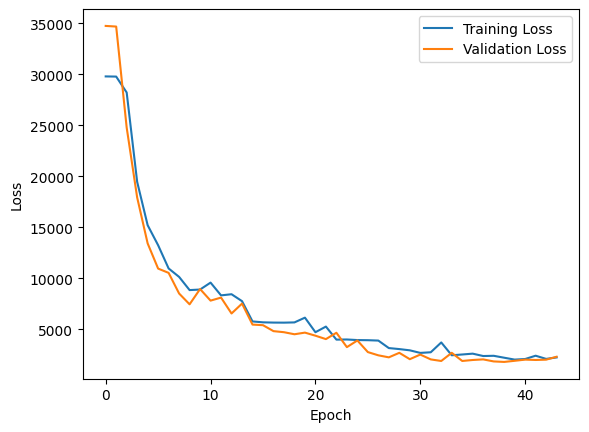

In [21]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


1/1 [==============================] - 1s 1s/step


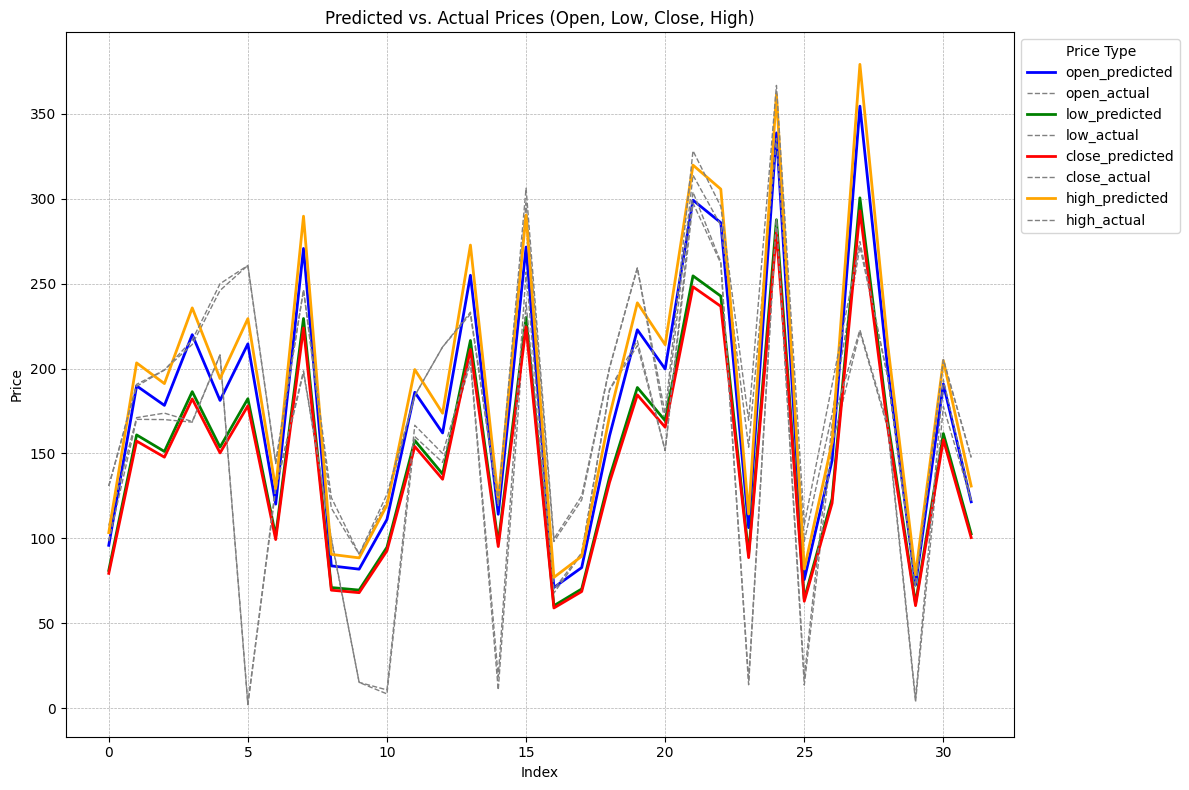

In [22]:
predictions = model.predict(X_test_reshaped)
idx = np.arange(predictions.shape[0])
colors = ['blue', 'green', 'red', 'orange']
plt.figure(figsize=(12, 8))

for i, (column_name, prediction_col) in enumerate(zip(['open', 'low', 'close', 'high'], predictions.T)):
    plt.plot(idx, prediction_col, label=f'{column_name}_predicted', color=colors[i], linewidth=2)
    plt.plot(idx, y_test.iloc[:, i], label=f'{column_name}_actual', color='gray', linestyle='--', linewidth=1)

plt.xlabel('Index')
plt.ylabel('Price')
plt.title('Predicted vs. Actual Prices (Open, Low, Close, High)')

plt.legend(loc='upper left', title='Price Type', bbox_to_anchor=(1, 1))

plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()
